In [1]:
import json
import sys

sys.path.append("/workspace/circuit-finder")
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results" / "animal_diet_long_prompts" / "batch_0"
assert results_dir.exists()

# Print Hparams

In [2]:
config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/animal_diet_long_prompts.json
save_dir: /workspace/circuit-finder/results/animal_diet_long_prompts
seed: 1
batch_size: 4
total_dataset_size: 32
ablate_errors: False
first_ablate_layer: 2
verbose: False


# Show Dataset

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

dataset = results_dir / "dataset.json"
with open(dataset, 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)
df.head()

,clean,answer,wrong_answer,corrupt
0,"<|endoftext|>""What do cows like to eat?"", Lucas asked his father. His father smiled and said, ""They like to eat",grass,flies,"<|endoftext|>""What do frogs like to eat?"", Daniel asked his father. His father smiled and said, ""They like to eat"
1,"<|endoftext|>""What do cows like to eat?"", Liam asked his grandmother. His grandmother smiled and said, ""They like to eat",grass,bananas,"<|endoftext|>""What do monkeys like to eat?"", Chloe asked her mother. Her mother smiled and said, ""They like to eat"
2,"<|endoftext|>""What do cows like to eat?"", Lily asked her teacher. Her teacher smiled and said, ""They like to eat",grass,lettuce,"<|endoftext|>""What do turtles like to eat?"", Oliver asked his grandmother. His grandmother smiled and said, ""They like to eat"
3,"<|endoftext|>""What do cows like to eat?"", Jack asked his grandmother. His grandmother smiled and said, ""They like to eat",grass,bread,"<|endoftext|>""What do ducks like to eat?"", Lucas asked his grandmother. His grandmother smiled and said, ""They like to eat"


# Plot Graph

Threshold: 0.001, n_edges: 7664
Threshold: 0.003, n_edges: 1033
Threshold: 0.006, n_edges: 376


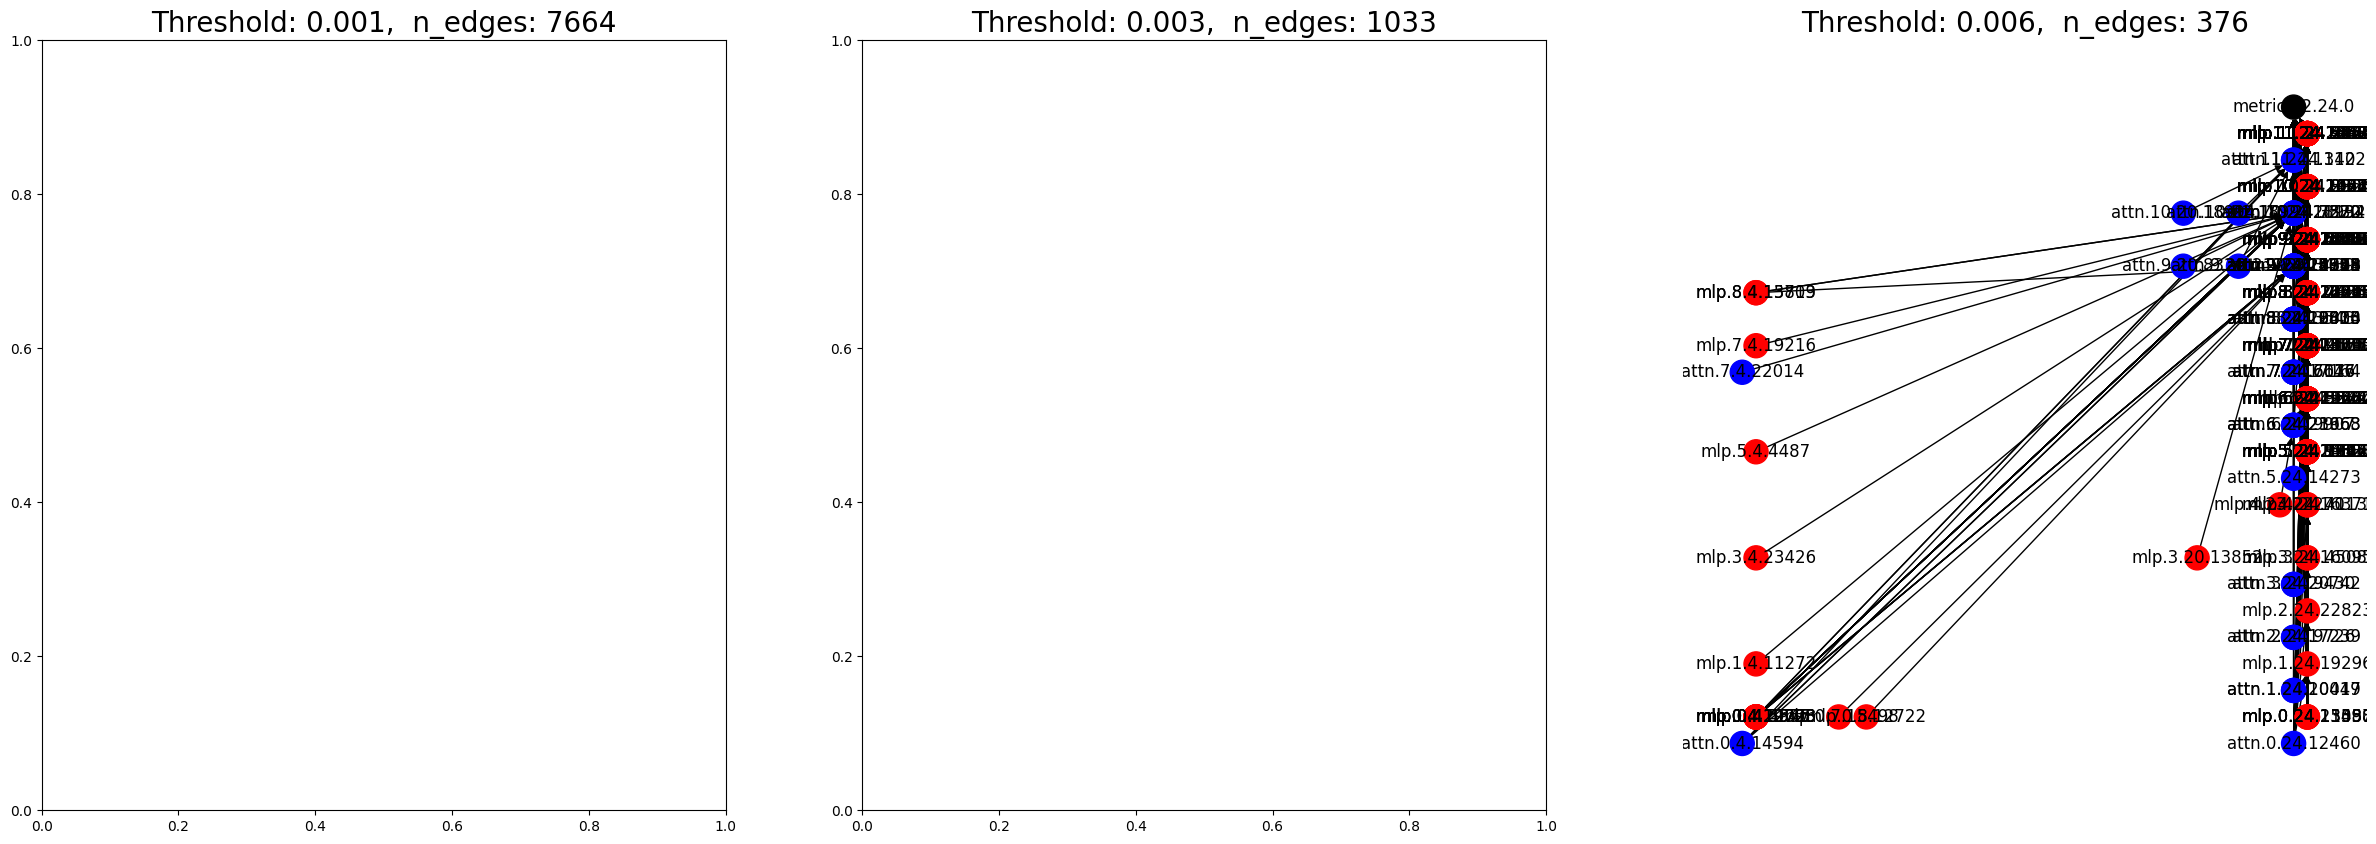

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
thresholds = [
    0.001,
    0.003,
    0.006,
    # 0.06,
]

for ax, threshold in zip(axs, thresholds):
    with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
        graph = EAPGraph.from_json(json.load(f))

    n_edges = len(graph.get_edges())
    print(f"Threshold: {threshold}, n_edges: {n_edges}")
    ax.set_title(f"Threshold: {threshold},  n_edges: {n_edges}", fontsize=20)

    if n_edges > 1000:
        continue
    show_attrib_graph(graph, ax=ax)


fig.show()

## Inspect the graph

In [5]:
threshold = 0.001
with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
    graph = EAPGraph.from_json(json.load(f))


In [6]:
## Print the distribution of nodes
import pandas as pd
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info in graph.graph:
    dest, src = edge
    if 'metric' in src: continue
    nn_grad, nn_attrib, em_grad, em_attrib = edge_info 
    src_module_type, src_layer, src_token, src_feature = parse_node_name(src)
    dest_module_type, dest_layer, dest_token, dest_feature = parse_node_name(dest)
    rows.append({
        "src_module_type": src_module_type,
        "dest_module_type": dest_module_type,
        "src_layer": src_layer,
        "dest_layer": dest_layer,
        "src_token": src_token,
        "dest_token": dest_token,
        "src_feature": src_feature,
        "dest_feature": dest_feature,
        "nn_grad": nn_grad,
        "nn_attrib": nn_attrib,
        "em_grad": em_grad,
        "em_attrib": em_attrib,
    })
df = pd.DataFrame(rows)
print(len(df))
df.head()

7639


,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,0,12,24,24,7197,0,0.007076,0.001959,0.007076,0.001959
1,mlp,metric,0,12,24,24,11331,0,0.006267,0.012265,0.006267,0.012265
2,mlp,metric,0,12,24,24,13587,0,0.008031,0.052145,0.008031,0.052145
3,mlp,metric,0,12,24,24,15498,0,0.003203,0.047060,0.003203,0.047060
4,mlp,metric,0,12,24,24,21024,0,0.004120,0.001556,0.004120,0.001556


Index(['src_layer', 'src_module_type', 'dest_module_type', 'dest_layer',
       'src_token', 'dest_token', 'src_feature', 'dest_feature', 'nn_grad',
       'nn_attrib', 'em_grad', 'em_attrib'],
      dtype='object')


Text(0.5, 1.0, 'Total edge attribution by src layer')

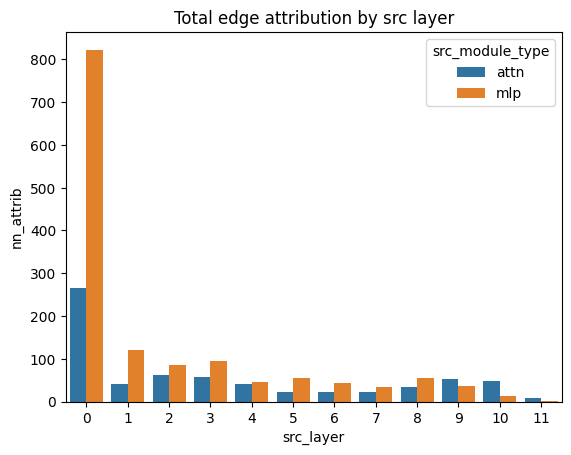

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

total_attrib_df = df.groupby(["src_layer", "src_module_type"]).sum().reset_index()
print(total_attrib_df.columns)
# Plot the total edge attribution by src layer
sns.barplot(x="src_layer", y="nn_attrib", data=total_attrib_df, hue="src_module_type")
plt.title("Total edge attribution by src layer")

Text(0.5, 1.0, 'Number of nodes in each layer')

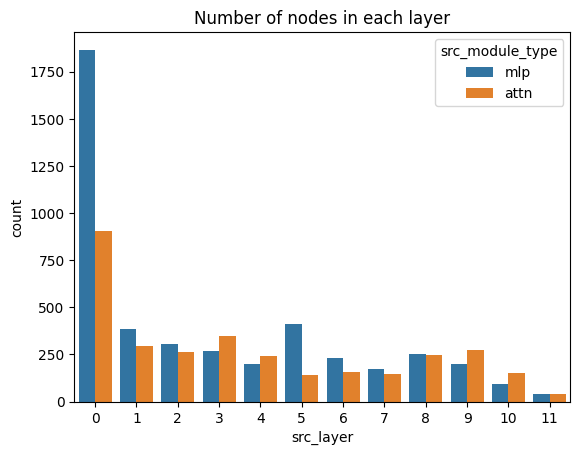

In [8]:
# Plot the number of nodes in each layer
sns.countplot(x="src_layer", data=df, hue="src_module_type")
plt.title("Number of nodes in each layer")

In [9]:
## Highest nodes by NN attrib

df.sort_values(by='em_attrib', ascending=False).head(10)

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
6975,mlp,mlp,0,1,24,24,15498,19296,0.649003,9.535811,0.066704,0.980081
344,attn,metric,10,12,24,24,18994,0,0.038522,0.372799,0.038522,0.372799
6130,mlp,mlp,0,2,24,24,15498,22823,0.362308,5.323393,0.024227,0.355966
7096,attn,mlp,0,1,24,24,12460,19296,0.243097,3.431298,0.024985,0.352666
6974,mlp,mlp,0,1,24,24,13587,19296,0.422513,2.743282,0.043425,0.281952
6993,mlp,mlp,0,1,22,22,21110,20991,0.391419,3.463635,0.029417,0.260305
110,mlp,metric,7,12,24,24,4557,0,0.022266,0.205993,0.022266,0.205993
333,attn,metric,9,12,24,24,21369,0,0.026026,0.202223,0.026026,0.202223
6991,mlp,mlp,0,1,22,22,19081,20991,0.391814,2.675875,0.029446,0.201102
6134,mlp,mlp,1,2,24,24,19296,22823,0.258224,2.883634,0.017267,0.192824


<Axes: xlabel='nn_attrib', ylabel='Count'>

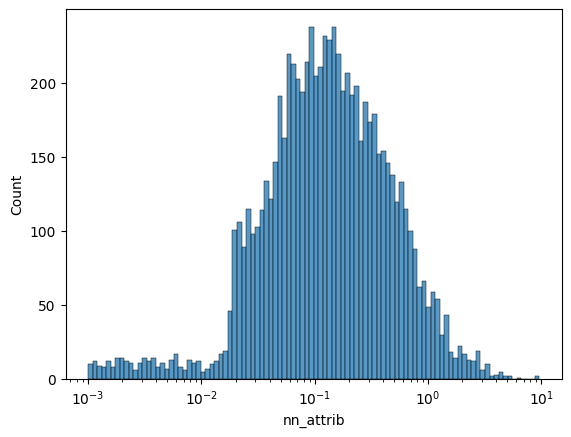

In [10]:
# Node-node activation histogram

sns.histplot(df['nn_attrib'], bins=100, log_scale = True)


#  Feature Dashboards

### Layer 9 Attention SAE Features

In [11]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

layer = 9

features = df[
    (df.src_layer == layer) & 
    (df.src_module_type == 'attn')
]['src_feature'].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%221795%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%223439%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%225493%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%226705%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%228973%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2211129%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2213121%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2213313%22%

In [12]:
layer = 10

features = df[(df.src_layer == layer) & (df.src_module_type == "attn")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%222077%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%223822%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%227570%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2216890%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2217400%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2218994%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2221132%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2

In [13]:
layer = 0

features = df[(df.src_layer == layer) & (df.src_module_type == "mlp")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "tres-dc")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%227197%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2211331%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2213587%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2215498%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2221024%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2223050%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%229326%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

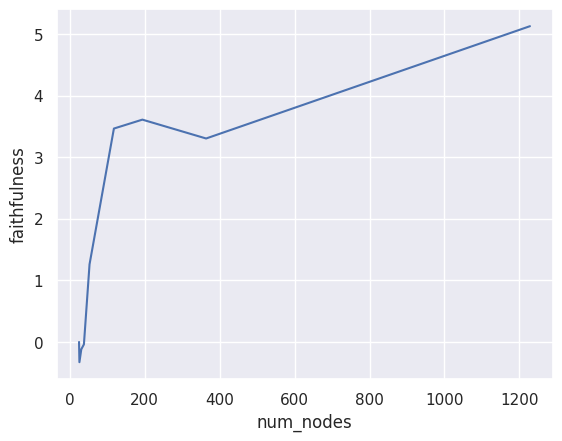

In [14]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")

In [15]:
faithfulness_df

,num_nodes,faithfulness
0,1228,5.130556
1,364,3.306004
2,194,3.612280
3,118,3.467497
4,53,1.261657
5,38,-0.038425
6,31,-0.118882
7,26,-0.328330
8,25,-0.000000
9,25,-0.000000


# Analysis: Utils test prompt with patching

Why the fuck is faithfulness so high? We need to test this by patching the model. 

In [16]:
dataset = results_dir / "dataset.json"
with open(dataset, "r") as f:
    dataset = json.load(f)

data_df = pd.DataFrame(dataset)
data_df.head()

,clean,answer,wrong_answer,corrupt
0,"<|endoftext|>""What do cows like to eat?"", Lucas asked his father. His father smiled and said, ""They like to eat",grass,flies,"<|endoftext|>""What do frogs like to eat?"", Daniel asked his father. His father smiled and said, ""They like to eat"
1,"<|endoftext|>""What do cows like to eat?"", Liam asked his grandmother. His grandmother smiled and said, ""They like to eat",grass,bananas,"<|endoftext|>""What do monkeys like to eat?"", Chloe asked her mother. Her mother smiled and said, ""They like to eat"
2,"<|endoftext|>""What do cows like to eat?"", Lily asked her teacher. Her teacher smiled and said, ""They like to eat",grass,lettuce,"<|endoftext|>""What do turtles like to eat?"", Oliver asked his grandmother. His grandmother smiled and said, ""They like to eat"
3,"<|endoftext|>""What do cows like to eat?"", Jack asked his grandmother. His grandmother smiled and said, ""They like to eat",grass,bread,"<|endoftext|>""What do ducks like to eat?"", Lucas asked his grandmother. His grandmother smiled and said, ""They like to eat"


In [17]:
from circuit_finder.patching.ablate import add_ablation_hooks_to_model
from circuit_finder.pretrained import load_mlp_transcoders, load_attn_saes, load_model
from circuit_finder.patching.leap import preprocess_attn_saes

model = load_model()
attn_saes = load_attn_saes()
attn_saes = preprocess_attn_saes(attn_saes, model)
mlp_transcoders = load_mlp_transcoders()


/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [30]:
print(len(graph.get_src_nodes()))

1228


In [40]:
import torch
from transformer_lens import utils

data_df["clean"] = data_df["clean"].apply(lambda x: x.lstrip("<|endoftext|>"))
data_df["corrupt"] = data_df["corrupt"].apply(lambda x: x.lstrip("<|endoftext|>"))
for i in range(len(data_df)):
    model.reset_hooks()
    tokens = model.to_tokens(data_df["clean"][i])
    corrupt_tokens = model.to_tokens(data_df["corrupt"][i])
    answer_tokens = model.to_tokens(data_df["answer"][i], prepend_bos=False)
    wrong_answer_tokens = model.to_tokens(data_df["wrong_answer"][i], prepend_bos=False)
    print(tokens)
    print(tokens.shape)
    print(corrupt_tokens.shape)
    print(model.to_str_tokens(corrupt_tokens))
    print(model.to_string(corrupt_tokens))
    # Test prompt without the ablation
    print("=" * 32)
    print("Without ablation")
    print("=" * 32)
    utils.test_prompt(data_df["clean"][i], data_df["answer"][i], model)
    utils.test_prompt(data_df["clean"][i], data_df["wrong_answer"][i], model)
    # Test prompt with the ablation
    
    # ablate_tokens = torch.cat([tokens, answer_tokens], dim=1)
    ablate_tokens = torch.cat([corrupt_tokens, wrong_answer_tokens], dim=1)
    
    model = add_ablation_hooks_to_model(
        model, graph, ablate_tokens, mlp_transcoders, attn_saes, ablate_nodes="bm", ablate_errors="bm"
    )
    print("=" * 32)
    print("Ablating outside circuit")
    print("=" * 32)
    utils.test_prompt(data_df["clean"][i], data_df["answer"][i], model)
    utils.test_prompt(data_df["clean"][i], data_df["wrong_answer"][i], model)
    break

tensor([[50256,     1,  2061,   466, 22575,   588,   284,  4483, 35379, 15257,
          1965,   465,  2988,    13,  2399,  2988, 13541,   290,   531,    11,
           366,  2990,   588,   284,  4483]], device='cuda:0')
torch.Size([1, 25])
torch.Size([1, 25])
['<|endoftext|>', '"', 'What', ' do', ' frogs', ' like', ' to', ' eat', '?",', ' Daniel', ' asked', ' his', ' father', '.', ' His', ' father', ' smiled', ' and', ' said', ',', ' "', 'They', ' like', ' to', ' eat']
['<|endoftext|>"What do frogs like to eat?", Daniel asked his father. His father smiled and said, "They like to eat']
Without ablation
Tokenized prompt: ['<|endoftext|>', '"', 'What', ' do', ' cows', ' like', ' to', ' eat', '?",', ' Lucas', ' asked', ' his', ' father', '.', ' His', ' father', ' smiled', ' and', ' said', ',', ' "', 'They', ' like', ' to', ' eat']
Tokenized answer: [' grass']


Performance on answer token:
Rank: 3        Logit: 13.94 Prob:  4.37% Token: | grass|

Top 0th token. Logit: 14.36 Prob:  6.70% Token: | meat|
Top 1th token. Logit: 13.96 Prob:  4.48% Token: |.|
Top 2th token. Logit: 13.95 Prob:  4.44% Token: |."|
Top 3th token. Logit: 13.94 Prob:  4.37% Token: | grass|
Top 4th token. Logit: 13.64 Prob:  3.24% Token: |,|
Top 5th token. Logit: 13.42 Prob:  2.60% Token: | the|
Top 6th token. Logit: 13.35 Prob:  2.44% Token: | a|
Top 7th token. Logit: 13.09 Prob:  1.88% Token: | their|
Top 8th token. Logit: 13.04 Prob:  1.79% Token: | milk|
Top 9th token. Logit: 12.94 Prob:  1.62% Token: | cow|


Ranks of the answer tokens: [(' grass', 3)]